In [9]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [10]:
train_dir = r"all_malware/train"
valid_dir = r"all_malware/valid"
test_dir  = r"all_malware/test"

image_size = (128, 128)

In [11]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    filenames = os.listdir(folder_path)
    print(f"Loading {len(filenames)} images from {folder_path}...")
    for filename in filenames:
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=image_size, color_mode='rgb')
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            
            # Assign label from filename
            label = 0 if 'clean' in filename.lower() else 1
            labels.append(label)
        except Exception as e:
            print(f"⚠️ Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(
    r"all_malware/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

valid_gen = datagen.flow_from_directory(
    r"all_malware/valid",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = datagen.flow_from_directory(
    r"all_malware/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 22820 images belonging to 59 classes.
Found 4891 images belonging to 59 classes.
Found 4890 images belonging to 59 classes.


In [26]:
plt.figure(figsize=(8,4))
for i in range(min(6, len(X_train))):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Clean" if y_train[i]==0 else "Trojaned")
    plt.axis('off')
plt.show()

<Figure size 800x400 with 0 Axes>

In [18]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=1
)


714/714 ━━━━━━━━━━━━━━━━━━━━ 230s 322ms/step - accuracy: 0.0152 - loss: -35476790642212864.0000 - val_accuracy: 0.0151 - val_loss: -85325624188600320.0000


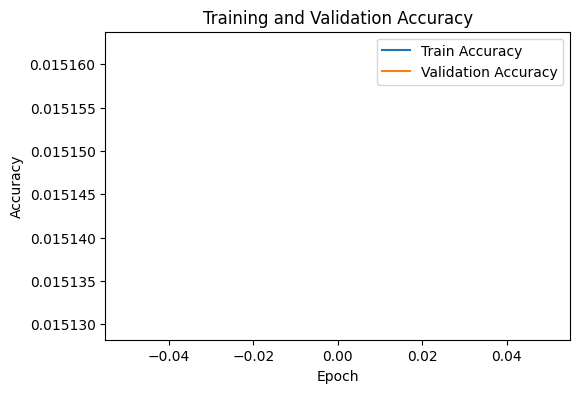

In [21]:
# ---------------- Plot Accuracy ----------------
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [24]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


153/153 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.0151 - loss: -85407116898074624.0000
✅ Test Accuracy: 0.0151, Test Loss: -85407116898074624.0000


In [ ]:
# ---------------- Save Model ----------------
model.save("trojan_detector.h5")
print("✅ Model saved as 'trojan_detector.h5'")

✅ Model saved as 'trojan_detector.h5'
